# Import and Constants

In [1]:
import os
import sys
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# Data Processing

## Loading Data

In [2]:
pth_data = Path('./query_result_v2.csv')
df_raw_data = pd.read_csv(pth_data)
df_raw_data = df_raw_data.convert_dtypes()
df_raw_data ['date_start'] = pd.to_datetime(df_raw_data['date_start'])
df_raw_data ['date_end'] = pd.to_datetime(df_raw_data['date_end'])
df_raw_data['price_sold'] = df_raw_data['price_sold'].astype(pd.Float64Dtype())

df_raw_data['br_final'] = df_raw_data['br_final'].astype(pd.StringDtype())
df_raw_data['id_community'] = df_raw_data['id_community'].astype(pd.StringDtype())
df_raw_data['id_municipality'] = df_raw_data['id_municipality'].astype(pd.StringDtype())

# column renaming
df_raw_data = df_raw_data.rename(
    columns={
        'topHighschoolScoreLevel': 'topHighschScore', 
        'topBelowHighschoolScoreLevel': 'topBelowHighschScore'
    }
)
print(df_raw_data.dtypes)


property_type           string[python]
br                               Int64
br_plus                          Int64
br_final                string[python]
bath_tot                         Int64
taxes                          Float64
lp_dol                           Int64
yr_built                string[python]
gar_type                string[python]
garage                         Float64
topHighschScore                Float64
topBelowHighschScore           Float64
geo_latitude                   Float64
geo_longitude                  Float64
lot_frontfeet                  Float64
lot_depthfeet                  Float64
sqft_numeric                     Int64
id_community            string[python]
id_municipality         string[python]
date_start              datetime64[ns]
date_end                datetime64[ns]
price_sold                     Float64
dtype: object


## Data Profiling

In [3]:
stats = df_raw_data.describe(include='all').transpose()
stats['missing'] = df_raw_data.isnull().sum()
stats['median'] = df_raw_data.median(numeric_only=True)
# stats = stats[['count', 'missing', 'unique', 'top', 'freq', 'min', 'mean', 'median', 'max','std']]
stats

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,missing,median
property_type,100000,32,D.,47047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,<NA>
br,98830.0,<NA>,<NA>,<NA>,2.766397,0.0,2.0,3.0,4.0,11.0,1.155085,1170,3.0
br_plus,40866.0,<NA>,<NA>,<NA>,1.213111,0.0,1.0,1.0,1.0,9.0,0.57466,59134,1.0
br_final,100000,65,3.0,22635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,<NA>
bath_tot,99997.0,<NA>,<NA>,<NA>,2.529286,0.0,2.0,2.0,3.0,18.0,1.302376,3,2.0
taxes,73911.0,<NA>,<NA>,<NA>,4030.752304,0.0,2457.0,3474.06,4686.965,694557.0,7635.764473,26089,3474.06
lp_dol,100000.0,<NA>,<NA>,<NA>,570960.49824,0.0,4599.75,459900.0,739900.0,89999900.0,790303.201775,0,459900.0
yr_built,44785,10,0-5,12307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55215,<NA>
gar_type,85315,8,Attached,34394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14685,<NA>
garage,99013.0,<NA>,<NA>,<NA>,1.26846,0.0,1.0,1.0,2.0,330.0,2.008628,987,1.0


## Removing duplicates

In [4]:
df_clean_data = df_raw_data.copy(deep=True)

df_clean_data = df_clean_data.drop_duplicates().copy(deep=True)
print(f'The number of duplicate rows is {df_raw_data.shape[0] - df_clean_data.shape[0]}.')

The number of duplicate rows is 43.


## Removing features

In [5]:
set_columns = set(df_clean_data.columns)
set_columns -= {'taxes', 'lot_frontfeet', 'lot_depthfeet', 'id_community', 'date_start', 'date_end'}

df_clean_data = df_clean_data[list(set_columns)]

## Handling Missing Data
+ `price_sold` (target variable) is an important feature but there are 29,269 missing values. Since the correlation between `price_sold` and `lp_dol` is 0.97 and there are no missing values for `lp_dol`, missing values of `price_sold` were replaced by `lp_dol` using a linear regression model. The distribution of price_sold was strange with 8,000 values under 50,000 while there was no values between 50,000 to 200,000. Values under 50,000 were removed.
+ `sqft_numeric` is critical for prediction, and imputation may introduce significant noise. Moreover, there is no correlation between `sqft_numeric` and `lot_frontfeet*lot_depthfeet`. So for algorithms that do not support missing values, corresponding rows should be dropped.
+ `bath_tot` feature is important feature and cannot be ignored. Although the missing values could be estimated but considering that there are only three missing values, corresponding rows were removed to save time.
+ While there are many missing values for `br` and `br_plus` feature, there is no missing values for `br_final` feature. Since `br_final` were calculated based on `br` and `br_plus`, the missing values can be reconstructed.

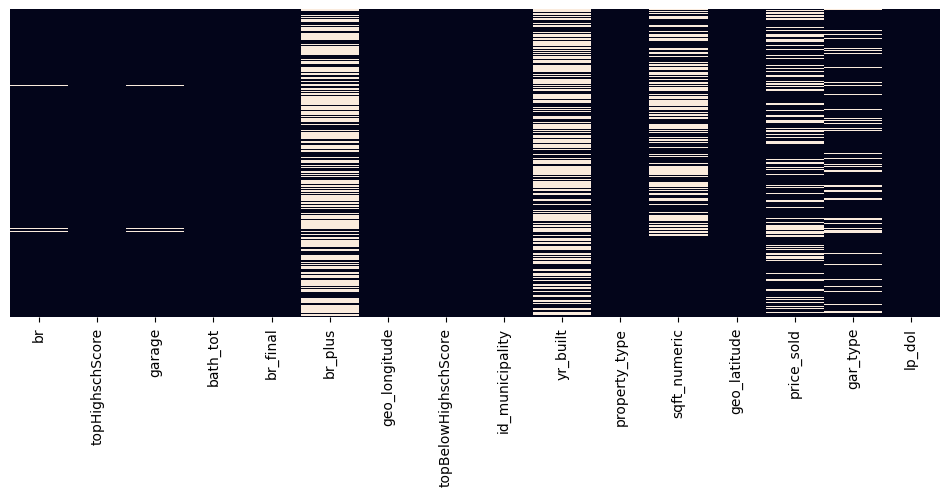

In [6]:
def plot_missing_values(df):
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False)

plot_missing_values(df_clean_data)

In [7]:
#region price_sold feature
# calculate the correlation between lp_dol and price_sold considering the missing values
corr = df_clean_data['lp_dol'].corr(df_clean_data['price_sold'], method='pearson')
print(f'The correlation between lp_dol and price_sold considering the missing values is {corr}.')

# estimate missing taxes values by linear regression
# select rows where price_sold is not missing and greater than 200000
idx_clean = (df_clean_data['price_sold'] > 200_000) & (df_clean_data['price_sold'].notna())
train_data = df_clean_data[idx_clean]
predict_data = df_clean_data[~idx_clean]
X_train, y_train = train_data[['lp_dol']], train_data['price_sold'] 

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing taxes using the trained model
X_predict = predict_data[['lp_dol']]
predicted_price = model.predict(X_predict)

# Assign the predicted values back to the DataFrame
df_clean_data.loc[~idx_clean, 'price_sold'] = predicted_price

# drop lp_dol column
df_clean_data = df_clean_data.drop('lp_dol', axis=1)
#endregion

#region sqft_numeric feature
# drop rows with missing values in sqft_numeric
df_clean_data = df_clean_data.dropna(subset=['sqft_numeric'])
#endregion

#region bath_tot feature
# drop rows with missing values in bath_tot
df_clean_data = df_clean_data.dropna(subset=['bath_tot'])
#endregion

#region br and br_plus features
# Reconstruct missing br and br_plus from br_final
df_clean_data[['br', 'br_plus']] = df_clean_data['br_final'].str.split('.', expand=True).astype(int)
df_clean_data = df_clean_data.drop('br_final', axis=1)
#endregion

#region gar_type feature
# replace missing values in gar_type with unknown string
df_clean_data['gar_type'] = df_clean_data['gar_type'].fillna('Unknown')
#endregion

#region yr_built feature
# replace missing values in yr_built with unknown string
df_clean_data['yr_built'] = df_clean_data['yr_built'].fillna('Unknown')
#endregion

#region topHighschScore and topBelowHighschScore features
# drop rows with missing values in topHighschScore and topBelowHighschScore
df_clean_data = df_clean_data.dropna(subset=['topHighschScore', 'topBelowHighschScore'])
#endregion

#region id_municipality feature
# drop rows with missing values in id_municipality
df_clean_data = df_clean_data.dropna(subset=['id_municipality'])
#endregion

The correlation between lp_dol and price_sold considering the missing values is 0.970256242857242.


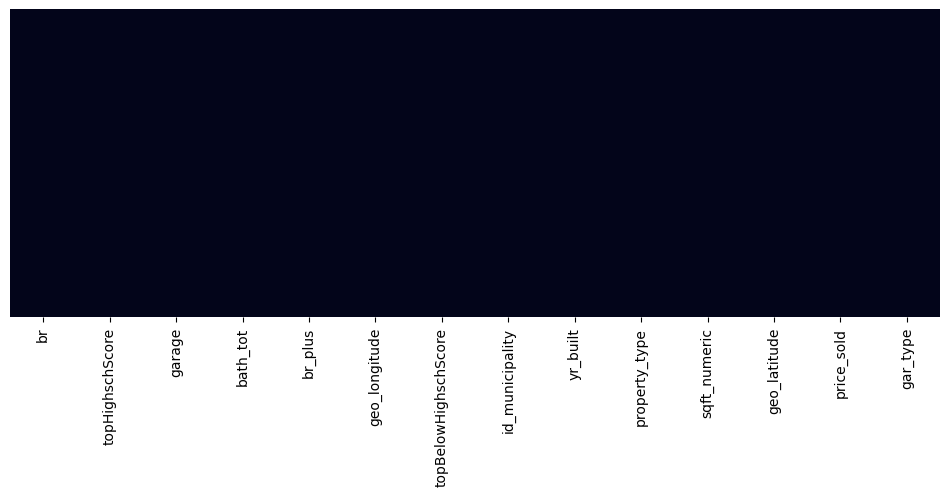

In [8]:
plot_missing_values(df_clean_data)

## Removing outliers

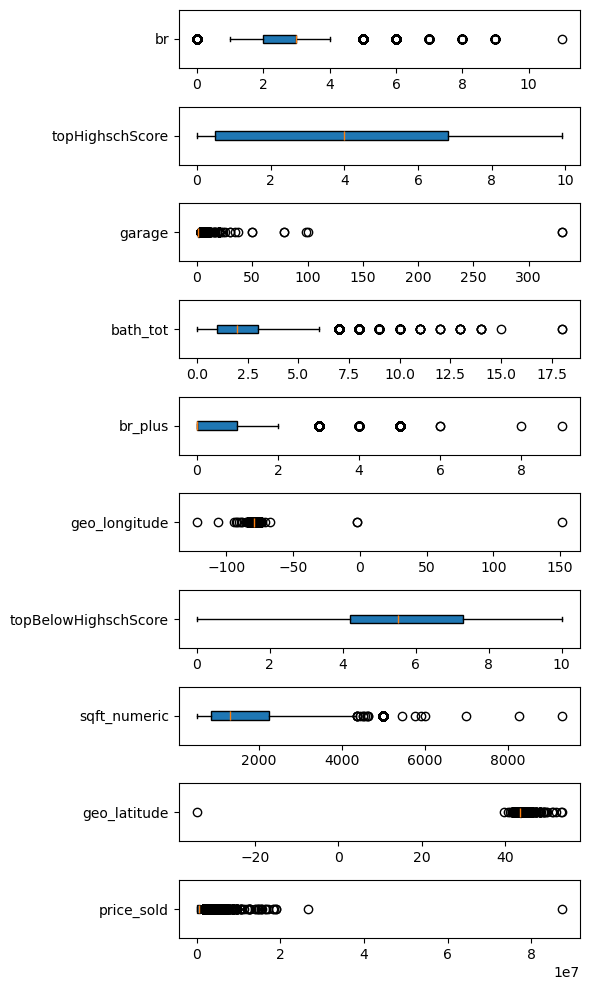

In [9]:
def plot_boxplots(df_data):
    # Select only numerical columns
    numerical_cols = df_data.select_dtypes(include=['number'])
    num_cols = numerical_cols.columns.size

    # Create subplots
    fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(6, num_cols))
    plt.subplots_adjust(hspace=0, wspace=0)

    # Generate box plots for each numerical column
    for ax, column in zip(axes, numerical_cols):
        df = df_data[[column]]
        df = df.dropna()
        ax.boxplot(df, vert=False, patch_artist=True)
        ax.set_yticks([1], [column])
        # ax.set_xticks([])

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_boxplots(df_clean_data)

+ Property type:
  + Any property type with less than 50 occurance were removed.
  + For simplicity, property types with less than 1k occurance were merged under `other` property type.

In [10]:
# drop property_type values that their count is less than 50 and rename values less than 1k to others
property_types_count = df_clean_data['property_type'].value_counts()
valid_property_types = property_types_count[property_types_count.gt(50)]
df_clean_data = df_clean_data[df_clean_data['property_type'].isin(valid_property_types.index)]

property_types_count = df_clean_data['property_type'].value_counts()
rename_property_types = property_types_count[property_types_count.lt(1000)]
df_clean_data.loc[df_clean_data['property_type'].isin(rename_property_types.index), 'property_type'] = 'others'

+ House Price: Rows with house price more than 10 million very removed.
+ Area: Rows with sqft more than 7k very removed.
+ Total Bathrooms: Rows with bathrooms more than 10 were removed.
+ Total Garage: Rows with garage more than 10 were removed.
+ Garage type has a value name `Underground` than should be renamed to `Undergrnd` value.

In [11]:
# Percentage of rows with price_sold greater than 2_000_000
print(sum(df_clean_data['price_sold'] > 2_000_000) / sum(df_clean_data['price_sold'] > 200_000))

# drop rows with price_sold less than 200_000
df_clean_data = df_clean_data[df_clean_data['price_sold'] > 200_000]

# remove sold_price feature with value more than 10E6
df_clean_data = df_clean_data[df_clean_data['price_sold'] <= 2_000_000]

# remove sold_price feature with value more than 10E6
df_clean_data = df_clean_data[df_clean_data['sqft_numeric'] <= 6_000]

# remove garage feature more than 10
df_clean_data = df_clean_data[df_clean_data['bath_tot'] <= 10]

# remove garage feature more than 10
df_clean_data = df_clean_data[df_clean_data['garage'] <= 10]

# remove geo_latitude feature less than 20
df_clean_data = df_clean_data[df_clean_data['geo_latitude'] >= 20]

# remove geo_longitude feature more than -50 and less than -100
df_clean_data = df_clean_data[df_clean_data['geo_longitude'] <= -50]
df_clean_data = df_clean_data[df_clean_data['geo_longitude'] >= -100]

# rename Underground to Undergrnd
df_clean_data.loc[df_clean_data['gar_type'] == 'Underground', 'gar_type'] = 'Undergrnd'

0.03901520823083998


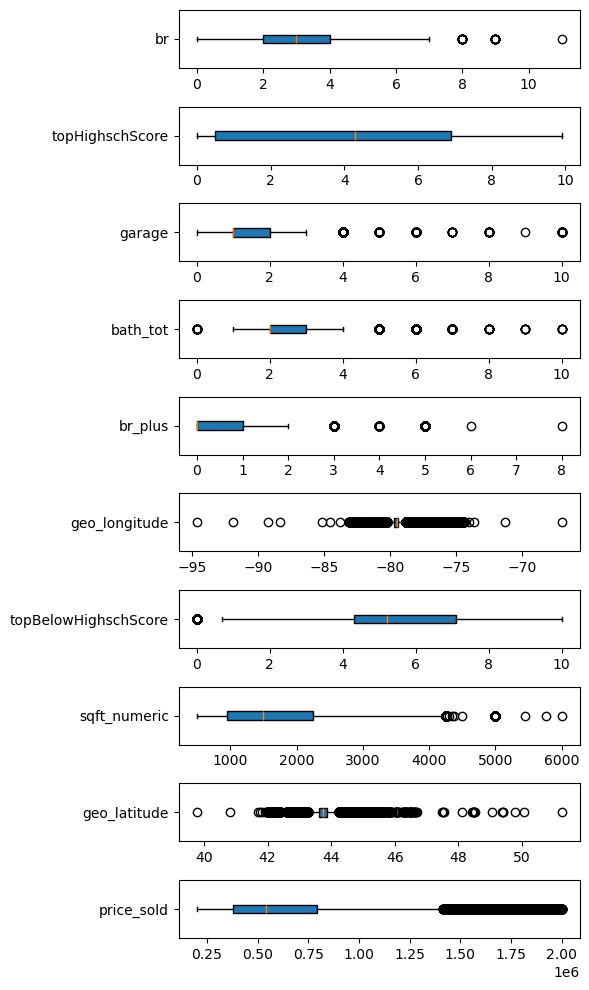

In [12]:
plot_boxplots(df_clean_data)

## Feature Engineering

In [13]:
df_feature_categorical = df_clean_data.copy(deep=True).reset_index(drop=True)

dict_types = {
    'yr_built': pd.CategoricalDtype(),
    'gar_type': pd.CategoricalDtype(),
    'property_type': pd.CategoricalDtype(),
    'id_municipality': pd.CategoricalDtype(),
}
df_feature_categorical = df_feature_categorical.astype(dict_types)

df_feature_categorical


,br,topHighschScore,garage,bath_tot,br_plus,geo_longitude,topBelowHighschScore,id_municipality,yr_built,property_type,sqft_numeric,geo_latitude,price_sold,gar_type
0,4,0.0,1.0,3,0,-79.857455,5.0,10103,New,A.,1750,44.316988,406400.0,Attached
1,5,5.3,1.0,4,2,-79.70644,3.7,10036,Unknown,D.,1750,43.72633,546000.0,Attached
2,5,8.0,9.0,6,2,-79.70566,7.0,10205,16-30,D.,4250,43.56173,1736000.0,Attached
3,4,0.0,2.0,4,2,-79.69424,5.0,10024,Unknown,D.,2750,44.41108,510000.0,Attached
4,3,5.7,2.0,3,0,-79.48897,6.1,10020,16-30,D.,2250,43.98397,1181700.0,Attached
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44880,2,0.5,2.0,3,0,-79.45166,2.3,10234,11-15,T.,1099,43.71479,474808.43537,Undergrnd
44881,2,0.3,0.0,1,0,-79.45446,7.8,10343,Unknown,T.,1099,43.67215,445000.0,Unknown
44882,1,5.1,1.0,1,0,-79.24765,7.1,10185,Unknown,T.,549,43.90131,212000.0,Surface
44883,1,0.5,1.0,2,5,-79.36099,2.6,10343,Unknown,C.,849,43.65035,525000.0,Undergrnd


## Feature Normalization

In [14]:
scaling = MinMaxScaler()
cols_selected = ['bath_tot', 'br_plus', 'topBelowHighschScore', 'topHighschScore', 'br', 'sqft_numeric', 'garage', 'geo_latitude', 'geo_longitude']
df_feature_categorical[cols_selected] = scaling.fit_transform(df_feature_categorical[cols_selected])

df_feature_categorical['price_sold'] = df_feature_categorical['price_sold'] / 1E3

# Exploratory data analysis

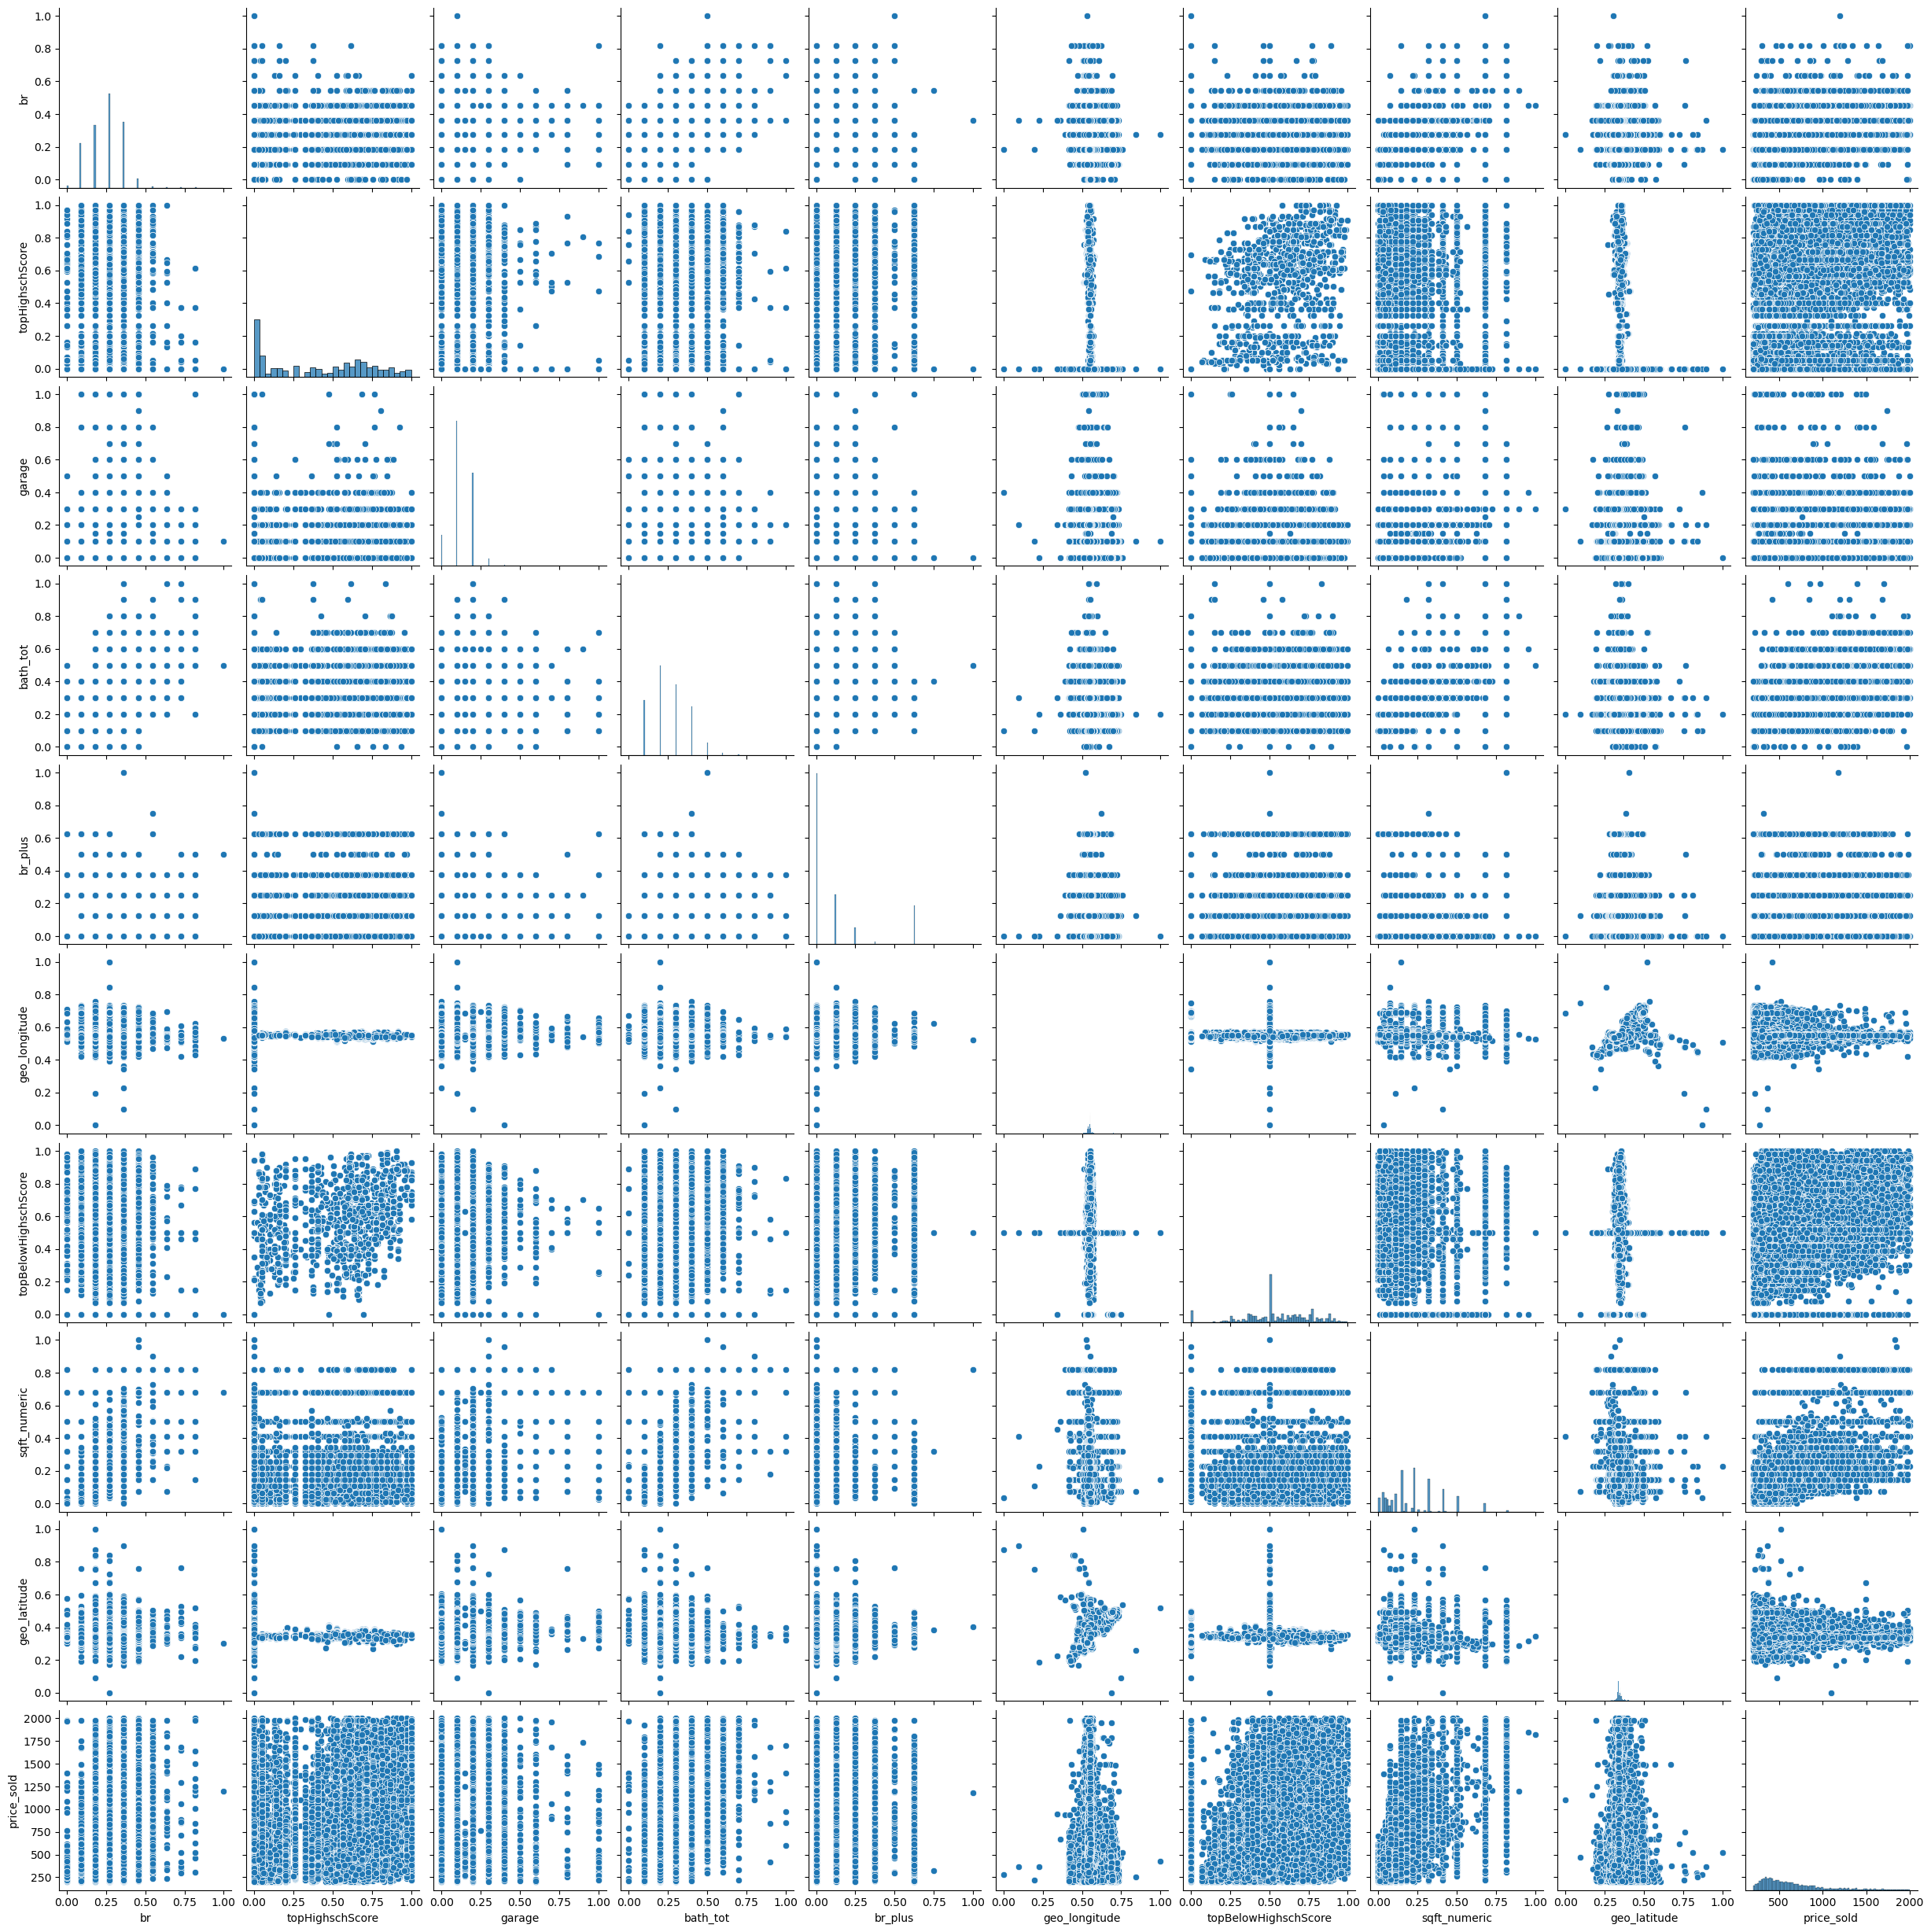

In [15]:
sns.pairplot(df_feature_categorical, kind="scatter")
plt.show()

# Model Building

## Data Encoding

### Lable Encoding

In [16]:
# Convert categorical variables to numerical using label encoding approach as XGBoost does not handle categorical variables
df_feature_label_encoding = df_feature_categorical.copy(deep=True)

le = LabelEncoder()

df_feature_label_encoding['yr_built'] = le.fit_transform(df_feature_label_encoding['yr_built'])
df_feature_label_encoding['gar_type'] = le.fit_transform(df_feature_label_encoding['gar_type'])
df_feature_label_encoding['property_type'] = le.fit_transform(df_feature_label_encoding['property_type'])
df_feature_label_encoding['id_municipality'] = le.fit_transform(df_feature_label_encoding['id_municipality'])

display(df_feature_label_encoding)

,br,topHighschScore,garage,bath_tot,br_plus,geo_longitude,topBelowHighschScore,id_municipality,yr_built,property_type,sqft_numeric,geo_latitude,price_sold,gar_type
0,0.363636,0.000000,0.1,0.3,0.000,0.534683,0.50,77,9,0,0.227413,0.395510,406.4,0
1,0.454545,0.535354,0.1,0.4,0.250,0.540155,0.37,28,10,2,0.227413,0.344089,546.0,0
2,0.454545,0.808081,0.9,0.6,0.250,0.540183,0.70,154,3,2,0.681876,0.329759,1736.0,0
3,0.363636,0.000000,0.2,0.4,0.250,0.540597,0.50,18,10,2,0.409198,0.403701,510.0,0
4,0.272727,0.575758,0.2,0.3,0.000,0.548034,0.61,15,3,2,0.318306,0.366518,1181.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44880,0.181818,0.050505,0.2,0.3,0.000,0.549386,0.23,179,2,4,0.109071,0.343084,474.808435,6
44881,0.181818,0.030303,0.0,0.1,0.000,0.549285,0.78,264,10,4,0.109071,0.339372,445.0,7
44882,0.090909,0.515152,0.1,0.1,0.000,0.556778,0.71,140,10,4,0.009089,0.359322,212.0,5
44883,0.090909,0.050505,0.1,0.2,0.625,0.552671,0.26,264,10,1,0.063625,0.337474,525.0,6


### One-Hot Encoding

In [17]:
df_feature_one_hot = df_feature_categorical.copy(deep=True)

encoder = OneHotEncoder()
categorical_columns = ['yr_built', 'gar_type', 'property_type']

encoded_features = encoder.fit_transform(df_feature_one_hot[categorical_columns])
encoded_features_dense = encoded_features.toarray()  # Converts sparse matrix to dense matrix
feature_names = encoder.get_feature_names_out(categorical_columns)  # Ensures feature names are correctly retrieved

encoded_df = pd.DataFrame(encoded_features_dense, columns=feature_names, index=df_feature_one_hot.index)

df_feature_one_hot = df_feature_one_hot.drop(columns=categorical_columns)
df_feature_one_hot = pd.concat([df_feature_one_hot, encoded_df], axis=1)

display(df_feature_one_hot)

,br,topHighschScore,garage,bath_tot,br_plus,geo_longitude,topBelowHighschScore,id_municipality,sqft_numeric,geo_latitude,...,gar_type_Other,gar_type_Surface,gar_type_Undergrnd,gar_type_Unknown,property_type_A.,property_type_C.,property_type_D.,property_type_S.,property_type_T.,property_type_others
0,0.363636,0.000000,0.1,0.3,0.000,0.534683,0.50,10103,0.227413,0.395510,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.454545,0.535354,0.1,0.4,0.250,0.540155,0.37,10036,0.227413,0.344089,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.454545,0.808081,0.9,0.6,0.250,0.540183,0.70,10205,0.681876,0.329759,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.363636,0.000000,0.2,0.4,0.250,0.540597,0.50,10024,0.409198,0.403701,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.272727,0.575758,0.2,0.3,0.000,0.548034,0.61,10020,0.318306,0.366518,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44880,0.181818,0.050505,0.2,0.3,0.000,0.549386,0.23,10234,0.109071,0.343084,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44881,0.181818,0.030303,0.0,0.1,0.000,0.549285,0.78,10343,0.109071,0.339372,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
44882,0.090909,0.515152,0.1,0.1,0.000,0.556778,0.71,10185,0.009089,0.359322,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44883,0.090909,0.050505,0.1,0.2,0.625,0.552671,0.26,10343,0.063625,0.337474,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Model type selection

In [18]:
lst_scenarios = ['LR', 'RF', 'XGB']
scenario = lst_scenarios[2]

## Data Splitting
Stratified data spliting based on property_type was performed

In [19]:
if scenario == 'LR':
    df = df_feature_one_hot.copy(deep=True)
    df = df.drop('id_municipality', axis=1)
    train, test = train_test_split(df, test_size=0.2, random_state=42)
else:
    df = df_feature_label_encoding.copy(deep=True)
    train, test = train_test_split(df, test_size=0.2, stratify=df['property_type'], random_state=42)


# Features and target variable
X_train = train.drop('price_sold', axis=1)
y_train = train['price_sold']
X_test = test.drop('price_sold', axis=1)
y_test = test['price_sold']

## Modeling and Hyperparameter Tuning

In [20]:
if scenario == 'LR':
    lr = LinearRegression()
    lr.fit(X_train, y_train)
elif scenario == 'RF':
    rf = RandomForestRegressor(random_state=42)
    rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
    rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='neg_mean_squared_error')
    rf_grid.fit(X_train, y_train)
    rf_best = rf_grid.best_estimator_
elif scenario == 'XGB':
    xgb = XGBRegressor(random_state=42)
    xgb_params = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'learning_rate': [0.1, 0.01]}
    xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='neg_mean_squared_error')
    xgb_grid.fit(X_train, y_train)
    xgb_best = xgb_grid.best_estimator_

In [27]:
xgb_best.eval_metric

# Model Evaluation

In [21]:
def evaluate_model(model, X, y):
    preds = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)
    try:
        msle = mean_squared_log_error(y, preds)
    except ValueError:
        msle = np.nan
    return {'RMSE': round(rmse), 'MAE': round(mae), 'R²': round(r2*100, 1), 'MSLE': round(msle, 3)}

if scenario == 'LR':
    lr_metrics = evaluate_model(lr, X_test, y_test)
    df_lr_metrics = pd.DataFrame(lr_metrics, index=[0])
    print("LR Metrics:\n", df_lr_metrics)
elif scenario == 'RF':
    rf_metrics = evaluate_model(rf_best, X_test, y_test)
    df_rf_metrics = pd.DataFrame(rf_metrics, index=[0])
    print("Random Forest Metrics:\n", df_rf_metrics)
elif scenario == 'XGB':
    xgb_metrics = evaluate_model(xgb_best, X_test, y_test)
    df_xgb_metrics = pd.DataFrame(xgb_metrics, index=[0])
    print("XGBoost Metrics:\n", df_xgb_metrics)

XGBoost Metrics:
    RMSE  MAE    R²   MSLE
0   122   71  88.8  0.027
